In [1]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import networkx as nx
import numpy as np 
import tqdm as tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor,KernelDensity
from scipy.stats import spearmanr
from sklearn.decomposition import PCA


In [2]:
# =========================
# Helper Functions
# =========================

def tune_isolation_forest(X, contaminations= np.linspace(0.01,0.2,10),estimators = np.linspace(50,200,4), n_runs=10):
    best_score = -np.inf
    best_params = None
    for estimator in estimators:
        for cont in contaminations:
            scores = []
            for _ in range(n_runs):
                iso = IsolationForest(
                    n_estimators=int(estimator),
                    max_samples='auto',
                    contamination=cont,
                    random_state=None
                )
                scores.append(iso.fit(X).score_samples(X))
            
            # Stability = average rank correlation
            corr = []
            for i in range(len(scores) - 1):
                corr.append(
                    spearmanr(scores[i], scores[i+1])[0]
                )
            
            stability = np.nanmean(corr)
            
            if stability > best_score:
                best_score = stability
                best_params = (int(estimator),cont)
                
        return best_params

def tune_lof(X):
    n = len(X)
    candidates = [int(np.sqrt(n)), int(1.5*np.sqrt(n)), int(2*np.sqrt(n))]
    candidates = [k for k in candidates if k < n]
    
    best_k = None
    best_sep = -np.inf
    
    for k in candidates:
        lof = LocalOutlierFactor(n_neighbors=k)
        scores = -lof.fit_predict(X)
        
        # Separation heuristic: std of LOF scores
        sep = np.std(lof.negative_outlier_factor_)
        
        if sep > best_sep:
            best_sep = sep
            best_k = k
            
    return best_k

def calculate_model_stability(scores_list):
    """
    Calculate model stability using Spearman rank correlation.

    Parameters:
    - scores_list: List of anomaly scores from multiple runs of the same model.

    Returns:
    - stability: Average Spearman rank correlation between runs.
    """
    correlations = []
    for i in range(len(scores_list) - 1):
        corr, _ = spearmanr(scores_list[i], scores_list[i + 1])
        correlations.append(corr)
    stability = np.nanmean(correlations)
    return stability

def calculate_model_agreement(labels1, labels2):
    """
    Calculate model agreement between two models.

    Parameters:
    - labels1: Anomaly labels from model 1.
    - labels2: Anomaly labels from model 2.

    Returns:
    - agreement: Proportion of data points where both models agree.
    """
    agreement = np.mean(labels1 == labels2)
    return agreement

def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() -
                          t * (s_unif > u).sum() / n_generated * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        print('\nFailed to achieve t_max\n')
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax

def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv

def plot_country_anomalies(country):
    country_df = (
        features_df[features_df['country'] == country]
        .sort_values('year')
        .set_index('year')
    )
    
    # Full year range to expose missing years
    full_years = np.arange(country_df.index.min(), country_df.index.max() + 1)
    country_full = country_df.reindex(full_years)
    
    # -------------------------------
    # Plot
    # -------------------------------
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(13, 8), sharex=True
    )
    
    # =========================================================
    # TOP: Weighted volumes
    # =========================================================
    ax1.plot(
        country_full.index,
        country_full['weighted_out_degree'],
        color='blue',
        linewidth=2,
        label='Exports'
    )
    
    ax1.plot(
        country_full.index,
        country_full['weighted_in_degree'],
        color='green',
        linewidth=2,
        label='Imports'
    )
    
    for col, color in [
        ('weighted_out_degree', 'blue'),
        ('weighted_in_degree', 'green')
    ]:
        y = country_full[col]
        valid_idx = np.where(~np.isnan(y.values))[0]
        for i in range(len(valid_idx) - 1):
            idx1, idx2 = valid_idx[i], valid_idx[i + 1]
            if idx2 - idx1 > 1:
                ax1.plot(
                    [y.index[idx1], y.index[idx2]],
                    [y.iloc[idx1], y.iloc[idx2]],
                    color=color,
                    linestyle=':',
                    linewidth=2,
                    alpha=0.8
                )
    
    # -------------------------------
    # Plot anomalies with three colors
    # -------------------------------
    iso_idx = country_full.index[country_full['iso_anomaly'] & ~country_full['lof_anomaly']]
    lof_idx = country_full.index[country_full['lof_anomaly'] & ~country_full['iso_anomaly']]
    joint_idx = country_full.index[country_full['iso_anomaly'] & country_full['lof_anomaly']]
    
    for year in iso_idx:
        ax1.axvline(x=year, color='cyan', linestyle='--', alpha=0.8, label='IF only' if year==iso_idx[0] else "")
    for year in lof_idx:
        ax1.axvline(x=year, color='magenta', linestyle='--', alpha=0.8, label='LOF only' if year==lof_idx[0] else "")
    for year in joint_idx:
        ax1.axvline(x=year, color='red', linestyle='-', linewidth=2, alpha=0.8, label='Overlap' if year==joint_idx[0] else "")
    
    ax1.set_ylabel('Weighted Arms Transfers (TIV)')
    ax1.set_title(f'{country} Arms Transfers: Volume')
    ax1.set_xlabel('Year')
    ax1.tick_params(axis='x', labelbottom=True)
    
    # =========================================================
    # BOTTOM: Connectivity (degrees)
    # =========================================================
    ax2.plot(
        country_full.index,
        country_full['out_degree'],
        color='blue',
        linewidth=2,

    )
    
    ax2.plot(
        country_full.index,
        country_full['in_degree'],
        color='green',
        linewidth=2,

    )
    
    for col, color in [
        ('out_degree', 'blue'),
        ('in_degree', 'green')
    ]:
        y = country_full[col]
        valid_idx = np.where(~np.isnan(y.values))[0]
        for i in range(len(valid_idx) - 1):
            idx1, idx2 = valid_idx[i], valid_idx[i + 1]
            if idx2 - idx1 > 1:
                ax2.plot(
                    [y.index[idx1], y.index[idx2]],
                    [y.iloc[idx1], y.iloc[idx2]],
                    color=color,
                    linestyle=':',
                    linewidth=2,
                    alpha=0.8
                )
    
    # -------------------------------
    # Plot anomalies for connectivity with same colors
    # -------------------------------
    for year in iso_idx:
        ax2.axvline(x=year, color='cyan', linestyle='--', alpha=0.8)
    for year in lof_idx:
        ax2.axvline(x=year, color='magenta', linestyle='--', alpha=0.8)
    for year in joint_idx:
        ax2.axvline(x=year, color='red', linestyle='-', linewidth=2, alpha=0.8)
    
    ax2.set_ylabel('Number of Trade Partners')
    ax2.set_xlabel('Year')
    ax2.set_title(f'{country} Arms Transfers: Network Connectivity')
    
    # =========================================================
    # Legend (shared)
    # =========================================================
    missing_line = mlines.Line2D(
        [], [], color='black', linestyle=':', linewidth=2,
        label='Missing Years (Interpolated)'
    )
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    # Add custom anomaly lines to legend
    handles = handles1 + handles2 
    labels = [h.get_label() for h in handles]
    
    fig.legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        ncol=4,
        frameon=False
    )
    
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f'results/{country}_lineplot_anomalies.png')
    plt.show()
    
def plot_pca_with_anomalies_combined(country, feature_cols=['year_scaled', 'in_degree', 'out_degree', 'weighted_in_degree', 'weighted_out_degree'], title="PCA Scatter Plot with Anomalies"):
    """
    Apply PCA to reduce the dataset to 2 dimensions and plot a single scatter plot
    with both Isolation Forest and LOF anomalies.

    Parameters:
    - country: The country to filter the data for.
    - feature_cols: List of column names to use for PCA.
    - title: Title of the plot.
    """

    data = (
        features_df[features_df['country'] == country]
        .sort_values('year')
        .set_index('year')
    )

    # Extract features and anomalies
    X = data[feature_cols].dropna()
    iso_anomalies = data.loc[X.index, 'iso_anomaly']  # Align with X
    lof_anomalies = data.loc[X.index, 'lof_anomaly']  # Align with X

    # Identify overlapping and individual anomalies
    overlap_anomalies = iso_anomalies & lof_anomalies
    iso_only_anomalies = iso_anomalies & ~lof_anomalies
    lof_only_anomalies = lof_anomalies & ~iso_anomalies
    normal_points = ~(iso_anomalies | lof_anomalies)

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[normal_points, 0], X_pca[normal_points, 1], c='blue', label='Normal', alpha=0.6)
    plt.scatter(X_pca[iso_only_anomalies, 0], X_pca[iso_only_anomalies, 1], c='cyan', label='IF only', alpha=0.8)
    plt.scatter(X_pca[lof_only_anomalies, 0], X_pca[lof_only_anomalies, 1], c='magenta', label='LOF only', alpha=0.8)
    plt.scatter(X_pca[overlap_anomalies, 0], X_pca[overlap_anomalies, 1], c='red', label='Overlap', alpha=0.8)

    # Add labels, legend, and grid
    plt.title(title, fontsize=16)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(f'results/{country}_scatterplot_anomalies.png')
    plt.show()

def plot_datapoints_per_year(df, year_left,year_right):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df.values, marker='o', linestyle='-', color='blue')
    plt.title('Number of Data Points Per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Data Points')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axvline(
            x=year_left,
            color='red',
            linestyle=':',
            linewidth=2,
            alpha=0.8
        )
    plt.axvline(
            x=year_right,
            color='red',
            linestyle=':',
            linewidth=2,
            alpha=0.8
        )
    plt.tight_layout()
    plt.savefig('results/data_points_per_year.png', format='png', dpi=300)
    plt.show()

In [3]:
# =========================
# 2. Load SIPRI Data and Preprocess
# =========================
# CSV must have columns: year, exporter, importer, tiv
df = pd.read_csv("data/trade-register.csv")

df.info()

#handling missing data and negative TIV values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Recipient                       14284 non-null  object 
 1   Supplier                        14286 non-null  object 
 2   Year of order                   14286 non-null  float64
 3                                   5899 non-null   object 
 4   Number ordered                  14176 non-null  float64
 5    .1                             5847 non-null   object 
 6   Weapon designation              14284 non-null  object 
 7   Weapon description              14284 non-null  object 
 8   Number delivered                14284 non-null  float64
 9    .2                             8124 non-null   object 
 10  Year(s) of delivery             14284 non-null  object 
 11  status                          14284 non-null  object 
 12  Comments                        

In [4]:
#Selecting relevant columns

df = df[['Year of order', 'Supplier', 'Recipient', 'SIPRI TIV for total order']]

In [5]:
#Removing rows with missing values
print(df.isna().sum())
df = df.dropna()

Year of order                0
Supplier                     0
Recipient                    2
SIPRI TIV for total order    4
dtype: int64


In [6]:
#Check for negative TIV values and remove them
df = df[df['SIPRI TIV for total order'] >= 0]

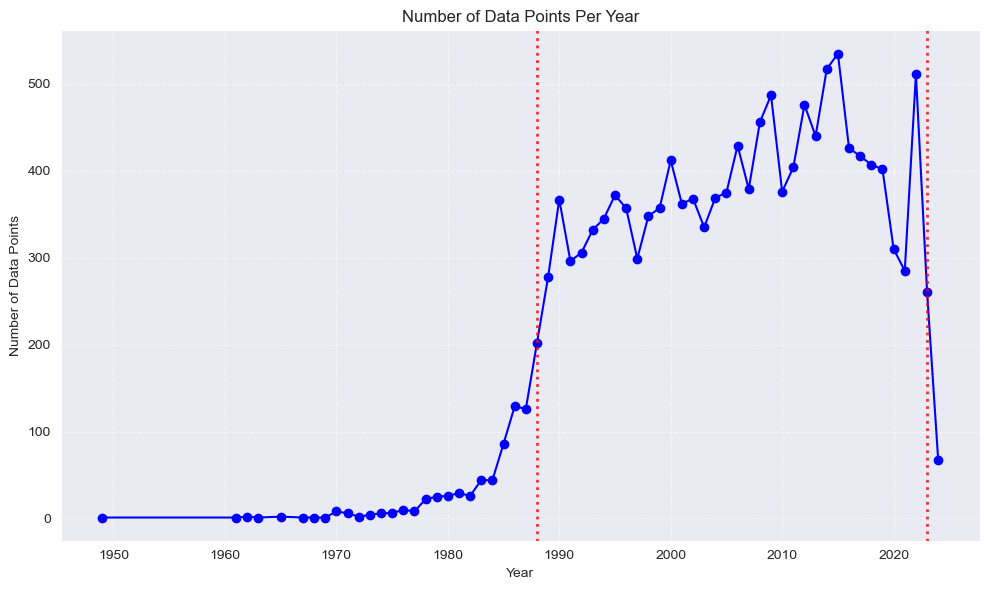

In [7]:
counts = (
    df.groupby('Year of order')
      .size()
      .reset_index(name="n_obs")
      .sort_values('Year of order')

)
counts["se_proxy"] = 1 / np.sqrt(counts["n_obs"])
counts["relative_se"] = (counts["se_proxy"] / counts["se_proxy"].min())

precision_threshold = 2.0

counts["precise_enough"] = (counts["relative_se"] <= precision_threshold)

precision_year_left = counts.loc[counts["precise_enough"], 'Year of order'].min()
precision_year_right = counts.loc[counts["precise_enough"], 'Year of order'].max()


# Plot the number of data points per year
data_points_per_year = df.groupby('Year of order').size()
plot_datapoints_per_year(data_points_per_year, precision_year_left, precision_year_right)

#reset dataframe to feasible bandwidth
df = df[(df['Year of order'] >= precision_year_left) & (df['Year of order'] <= precision_year_right)]


In [8]:
# =========================
# 3. Create Yearly Graphs
# =========================
graphs_by_year = {}
for year, year_df in df.groupby('Year of order'):
    G = nx.DiGraph(year=year)
    for _, row in year_df.iterrows():
        exporter = row['Supplier']
        importer = row['Recipient']
        tiv = row['SIPRI TIV for total order']
        if G.has_edge(exporter, importer):
            G[exporter][importer]['weight'] += tiv
        else:
            G.add_edge(exporter, importer, weight=tiv)
    graphs_by_year[year] = G

# =========================
# 4. Compute Node Features
# =========================
all_features = []
for year, G in graphs_by_year.items():
    for node in G.nodes:
        all_features.append({
            'year': year,
            'country': node,
            'in_degree': G.in_degree(node),
            'out_degree': G.out_degree(node),
            'weighted_in_degree': G.in_degree(node, weight='weight'),
            'weighted_out_degree': G.out_degree(node, weight='weight')
        })

features_df = pd.DataFrame(all_features)

In [9]:
# ===============================
# 5. Build full country–year grid
# ===============================

features_df = (
    features_df
    .set_index(['year', 'country'])
    .reindex(
        pd.MultiIndex.from_product(
            [features_df['year'].unique(),
             features_df['country'].unique()],
            names=['year', 'country']
        )
    )
    .reset_index()
)
# ================================================================
# 6. Rescale years linearly for extra feature in anomaly detection
# ================================================================

features_df['year_scaled'] = MinMaxScaler().fit_transform(features_df[['year']])




In [10]:
feature_cols = [
    'year_scaled',
    'in_degree',
    'out_degree',
    'weighted_in_degree',
    'weighted_out_degree'
]

minimum_data_points = np.round((precision_year_right - precision_year_left) * 0.8, 0)
print(f"Minimum data points per country: {minimum_data_points}")

Minimum data points per country: 28.0


In [11]:
# ===============================================================================================================================
# 7. Train and fit IsolationForest, LocalOutlierFactor, and combine them per country. Evaluate Country Performace and store in DF
# ==============================================================================================================================

evaluation_rows = []

features_df['iso_anomaly'] = False
features_df['lof_anomaly'] = False
features_df['combined_anomaly'] = False

for country, df_c in tqdm.tqdm(
    features_df.groupby('country'),
    desc="Processing countries"
):
    df_c = df_c.sort_values('year_scaled').dropna()

    if len(df_c) < minimum_data_points:
        continue

    X = df_c[feature_cols].values

    # ---------------------------
    # Hyperparameter tuning
    # ---------------------------
    best_param_iso = tune_isolation_forest(X)
    best_k = tune_lof(X)

    # ---------------------------
    # Fit Isolation Forest
    # ---------------------------
    iso = IsolationForest(
        n_estimators=best_param_iso[0],
        contamination=best_param_iso[1],
        random_state=42
    )
    iso_scores = iso.fit(X).decision_function(X)
    iso_labels = iso_scores < np.percentile(
        iso_scores, 100 * best_param_iso[1]
    )


    # ---------------------------
    # Fit LOF
    # ---------------------------
    lof = LocalOutlierFactor(n_neighbors=best_k)
    lof_labels = lof.fit_predict(X) == -1
    lof_scores = -lof.negative_outlier_factor_


    # ---------------------------
    # Combine LOF and IF
    # ---------------------------
    combined_scores = (iso_scores + lof_scores) / 2  # Average of scores
    combined_labels = combined_scores < np.percentile(
        combined_scores, 100 * best_param_iso[1]
    )

    # ---------------------------
    # Update features_df with anomaly labels
    # ---------------------------
    features_df.loc[df_c.index, 'iso_anomaly'] = iso_labels
    features_df.loc[df_c.index, 'lof_anomaly'] = lof_labels
    features_df.loc[df_c.index, 'combined_anomaly'] = combined_labels
    
    iso_stability = calculate_model_stability([iso_scores for _ in range(10)])  # Example: 10 runs
    lof_stability = calculate_model_stability([lof_scores for _ in range(10)])  # Example: 10 runs

    # ---------------------------
    # Model Agreement
    # ---------------------------
    model_agreement = calculate_model_agreement(iso_labels, lof_labels)

    # Append evaluation results
    evaluation_rows.append({
        'country': country,
        'iso_stability': calculate_model_stability([iso_scores for _ in range(10)]),
        'lof_stability': calculate_model_stability([lof_scores for _ in range(10)]),
        'model_agreement': calculate_model_agreement(iso_labels, lof_labels),
    })

# Convert evaluation results to DataFrame
evaluation_df = pd.DataFrame(evaluation_rows)


Processing countries: 100%|██████████| 221/221 [02:20<00:00,  1.58it/s]

                country  iso_stability  lof_stability  model_agreement
0               Algeria            1.0            1.0         0.885714
1                Angola            1.0            1.0         0.655172
2             Argentina            1.0            1.0         0.794118
3             Australia            1.0            1.0         0.805556
4               Austria            1.0            1.0         0.818182
..                  ...            ...            ...              ...
60       United Kingdom            1.0            1.0         0.861111
61        United States            1.0            1.0         0.805556
62              Uruguay            1.0            1.0         0.862069
63             Viet Nam            1.0            1.0         0.793103
64  unknown supplier(s)            1.0            1.0         0.857143

[65 rows x 4 columns]


In [12]:
evaluation_df.describe()

,iso_stability,lof_stability,model_agreement
count,6.500000e+01,6.500000e+01,65.000000
mean,1.000000e+00,1.000000e+00,0.780738
std,8.326673e-17,1.000742e-16,0.105611
min,1.000000e+00,1.000000e+00,0.428571
25%,1.000000e+00,1.000000e+00,0.714286
50%,1.000000e+00,1.000000e+00,0.805556
75%,1.000000e+00,1.000000e+00,0.857143
max,1.000000e+00,1.000000e+00,0.970588


In [13]:

# Melt the DataFrame to long format for easier plotting
melted_df = evaluation_df.melt(
    id_vars=['country'],
    value_vars=[
        'precision_combined', 'recall_combined', 'f1_combined', 'auc_roc_combined'
    ],
    var_name='Metric',
    value_name='Value'
)

# Create the boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Metric', y='Value', data=melted_df)
plt.title('Boxplot of Evaluation Metrics (Including New Metrics)')
plt.ylabel('Value')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['precision_combined', 'recall_combined', 'f1_combined', 'auc_roc_combined']"

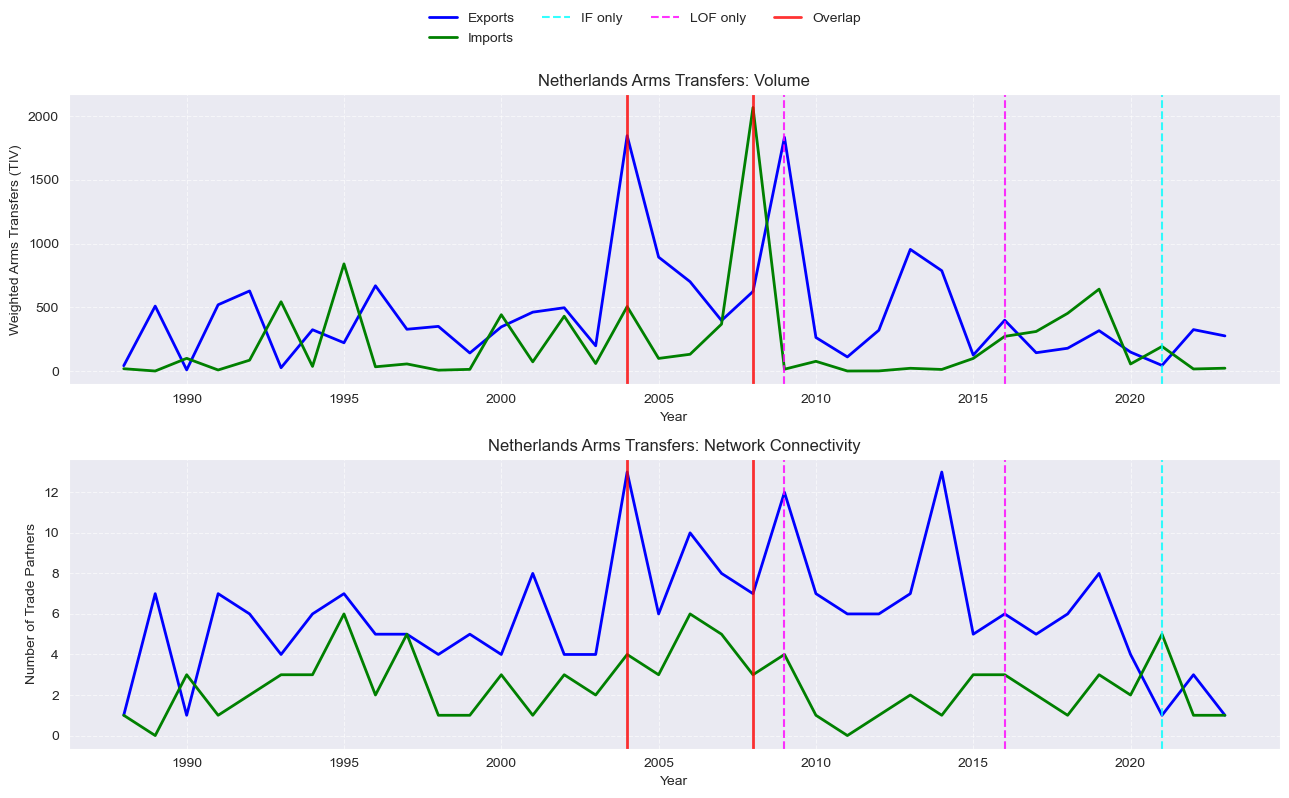

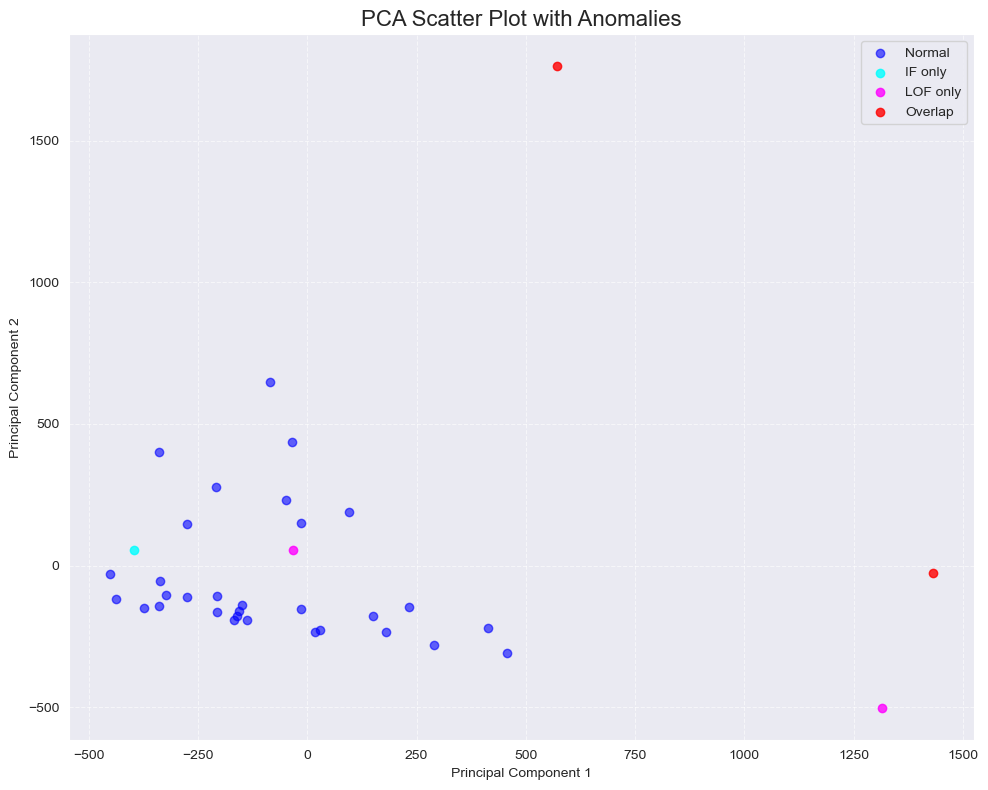

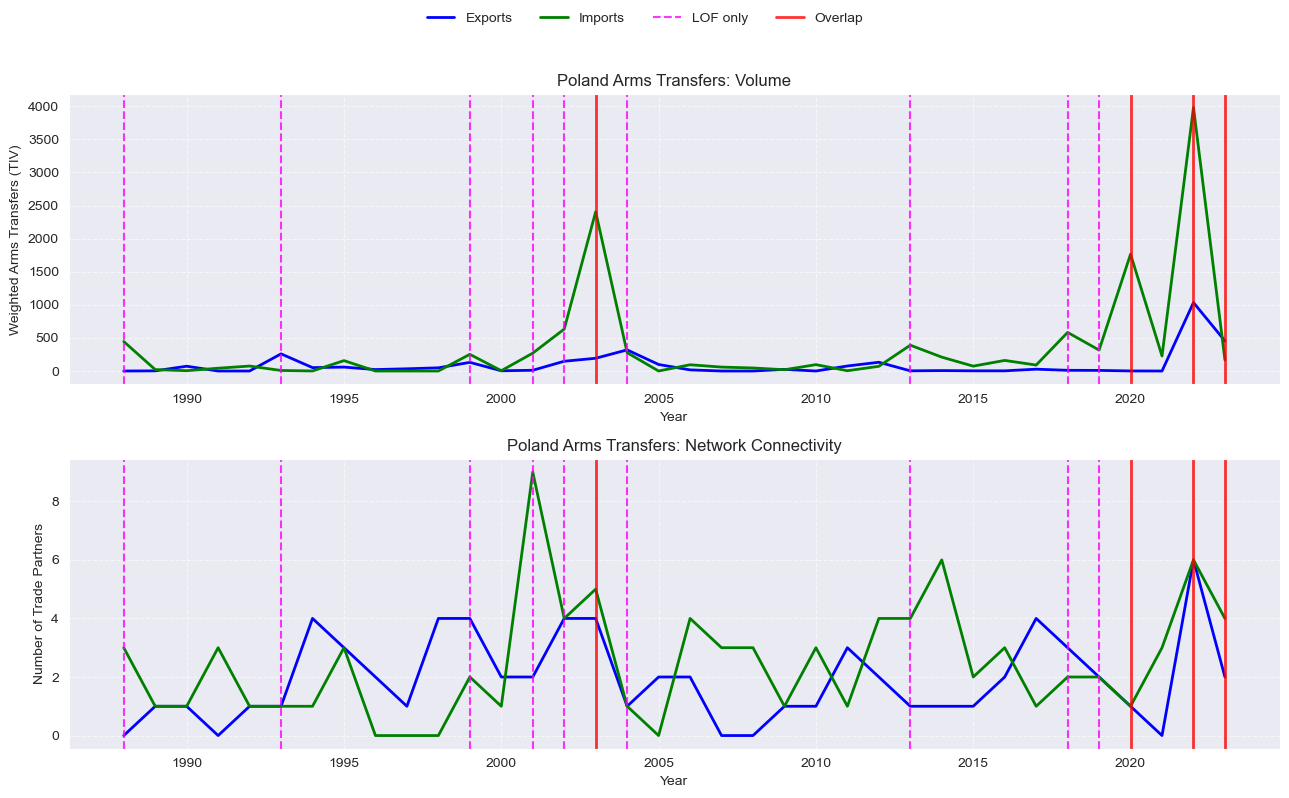

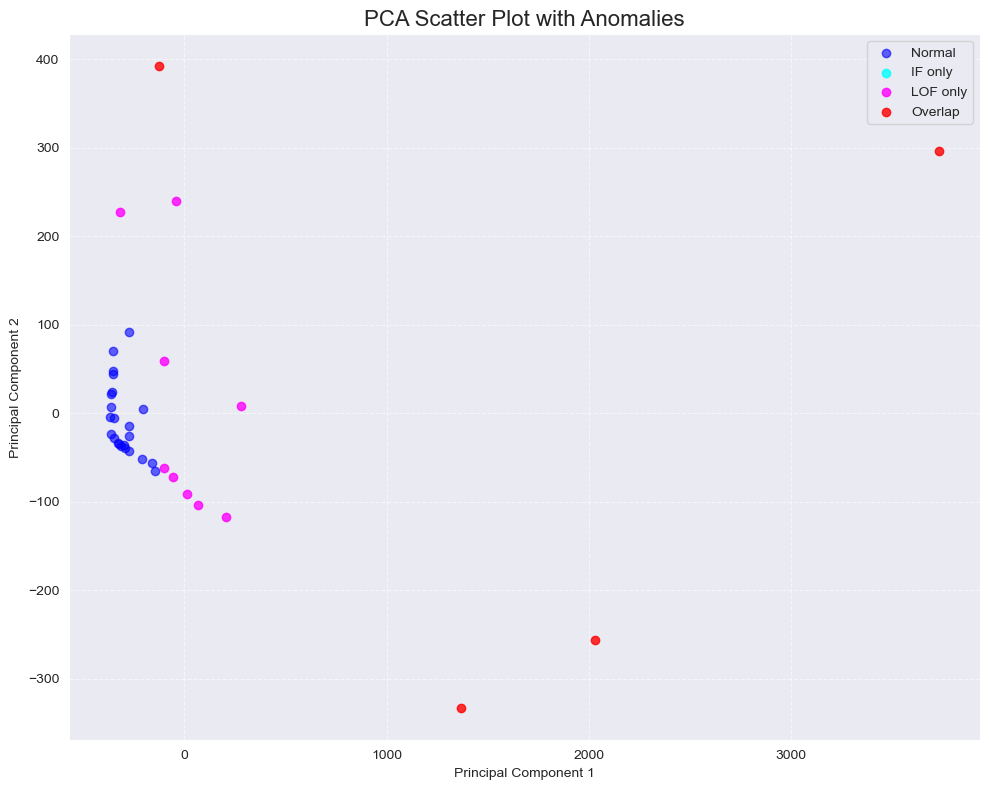

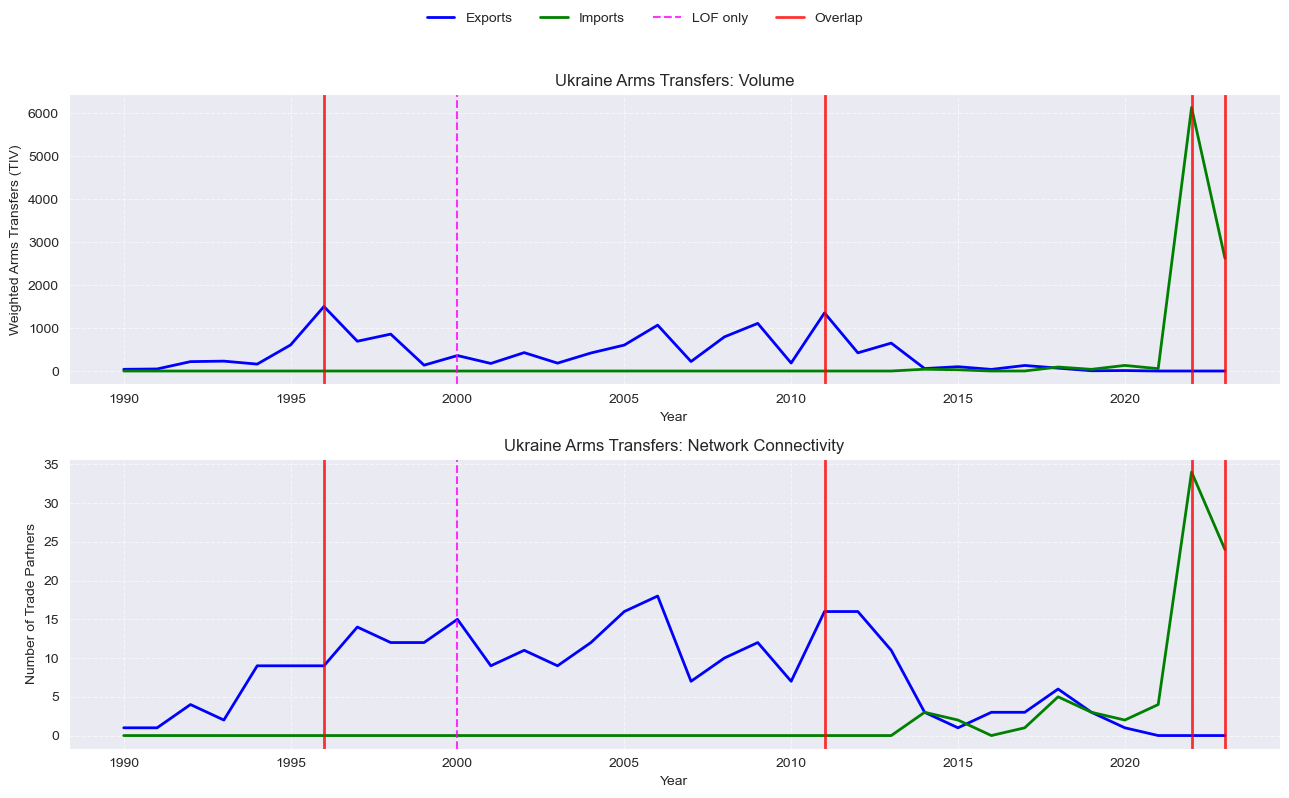

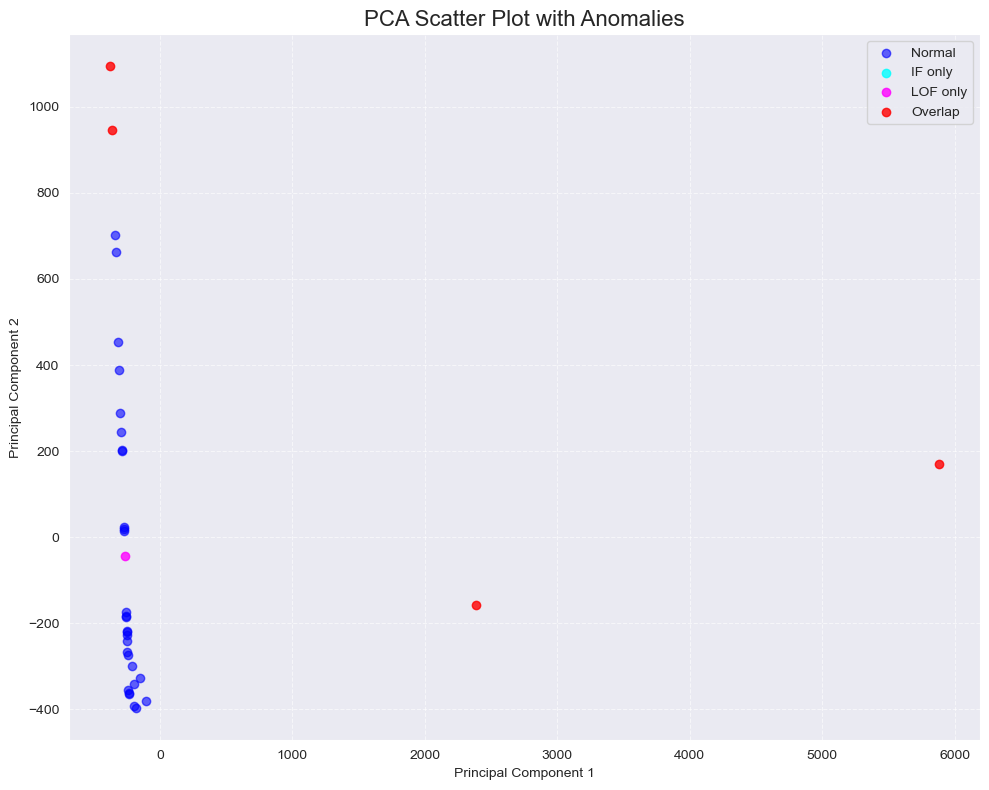

In [14]:
countries = ['Netherlands', 'Poland' , 'Ukraine']

for country in countries:
    plot_country_anomalies(country)
    plot_pca_with_anomalies_combined(country)



IsolationForest processing...
LocalOutlierFactor processing...


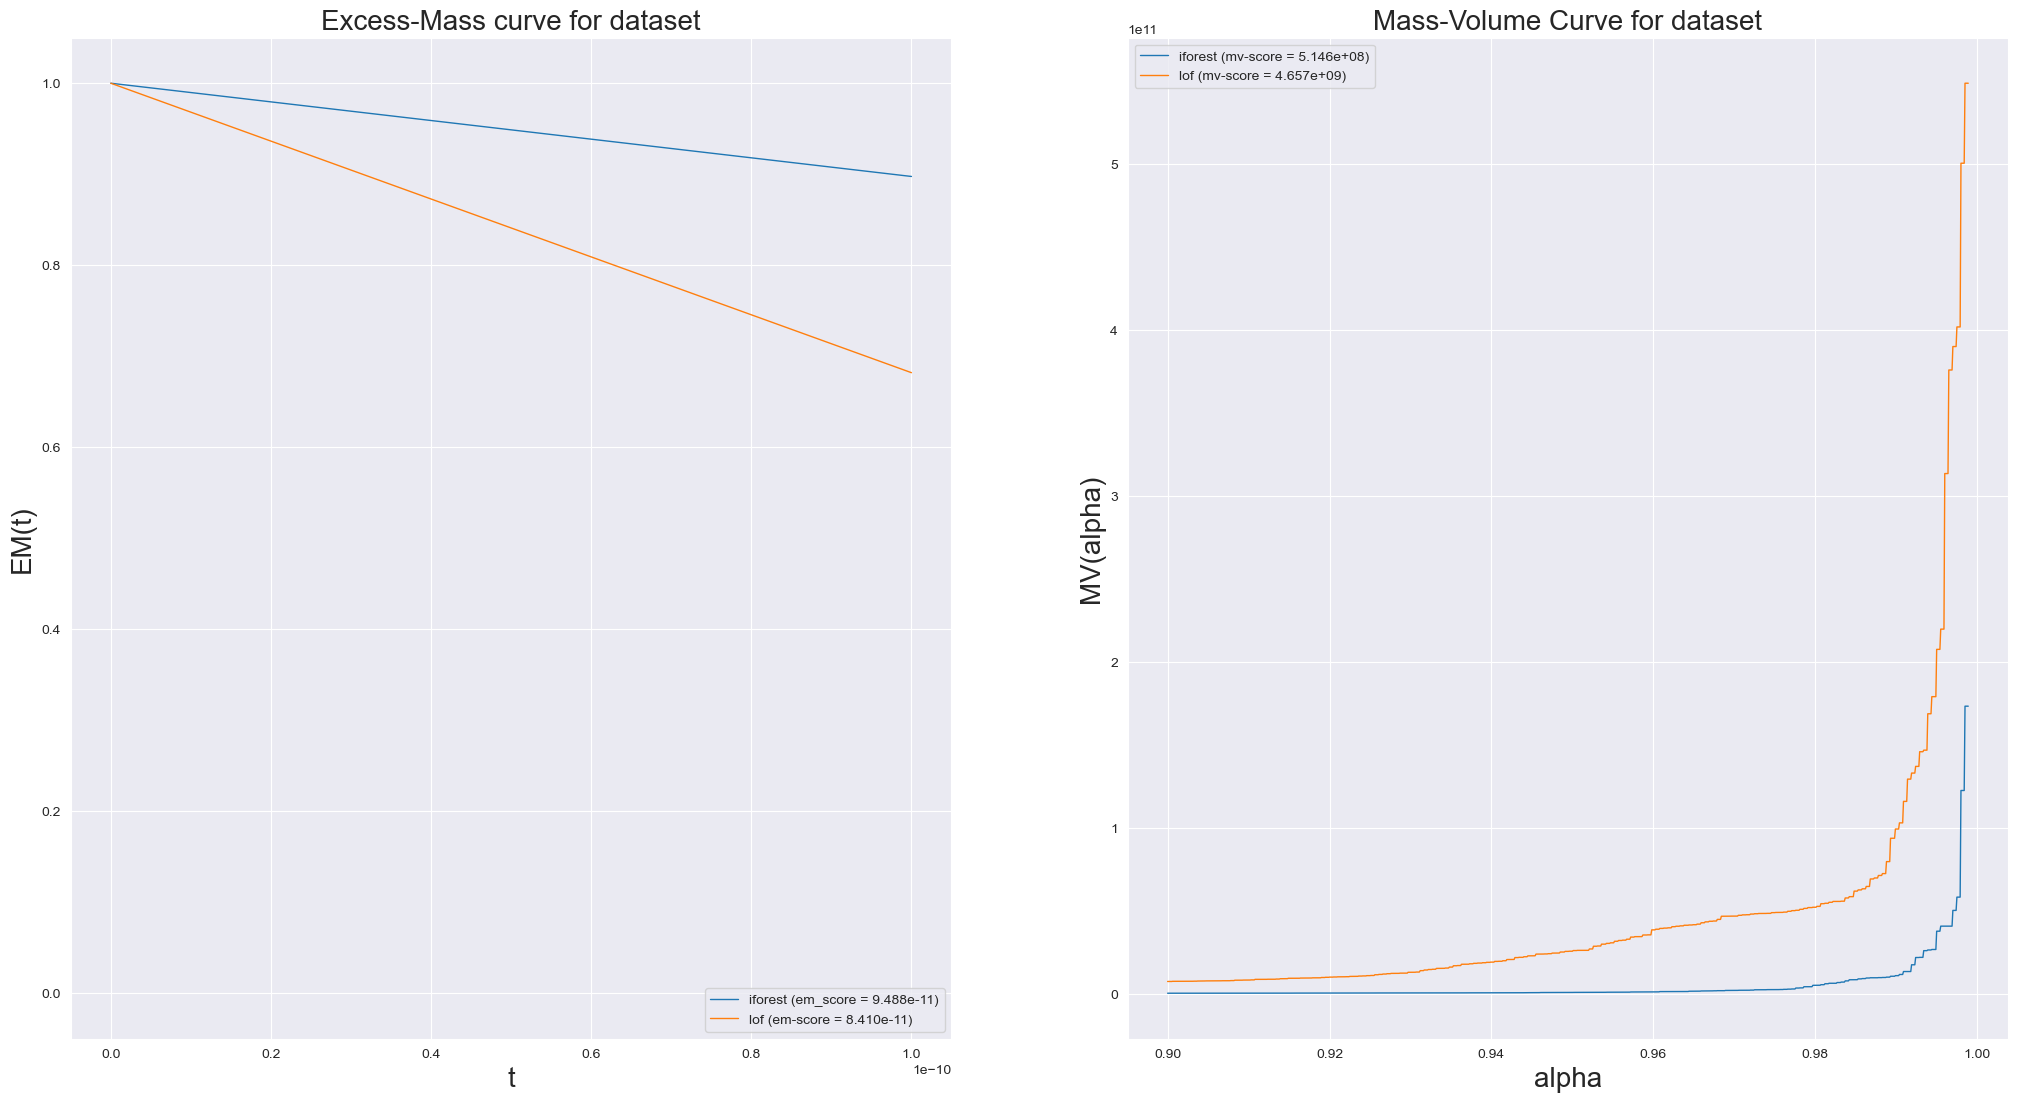

In [15]:
#Based On https://github.com/ngoix/EMMV_benchmarks/blob/master/em.py

import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import auc

# Parameters of the algorithm
n_generated = 100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9
ocsvm_max_train = 10000

np.random.seed(42)

plt.figure(figsize=(25, 13))

# Loading and vectorization
X = features_df[feature_cols].dropna().values

n_samples, n_features = np.shape(X)
n_samples_train = n_samples // 2
n_samples_test = n_samples - n_samples_train

X_train = X[:n_samples_train, :]
X_test = X[n_samples_train:, :]



best_param_iso = tune_isolation_forest(X)
best_k = tune_lof(X)

# ---------------------------
# Fit Isolation Forest
# ---------------------------
iforest = IsolationForest(
n_estimators=best_param_iso[0],
contamination=best_param_iso[1],
)
lof = LocalOutlierFactor(n_neighbors=best_k, novelty=True)



lim_inf = X.min(axis=0)
lim_sup = X.max(axis=0)

# Calculate volume_support
volume_support = (lim_sup - lim_inf).prod()


if volume_support <= 0:
    raise ValueError("volume_support is zero or negative. Check your input data.")


step_size = max(0.01 / volume_support, 1e-10)  # Ensure step size is not too small
t = np.arange(0, 100 / volume_support, step_size)
axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
unif = np.random.uniform(lim_inf, lim_sup, size=(n_generated, n_features))


print('IsolationForest processing...')
iforest.fit(X_train)
s_X_iforest = iforest.decision_function(X_test)

print('LocalOutlierFactor processing...')
lof.fit(X_train)
s_X_lof = lof.decision_function(X_test)


s_unif_iforest = iforest.decision_function(unif)
s_unif_lof = lof.decision_function(unif)





plt.subplot(121)
auc_iforest, em_iforest, amax_iforest = em(t, t_max, volume_support, s_unif_iforest, s_X_iforest, n_generated)
auc_lof, em_lof, amax_lof = em(t, t_max, volume_support, s_unif_lof, s_X_lof, n_generated)


if amax_iforest == -1 or amax_lof == -1:
    amax = -1
else:
    amax = max(amax_iforest, amax_lof)

plt.plot(t[:amax], em_iforest[:amax], lw=1, label='%s (em_score = %0.3e)' % ('iforest', auc_iforest))
plt.plot(t[:amax], em_lof[:amax], lw=1, label='%s (em-score = %0.3e)' % ('lof', auc_lof))


plt.ylim([-0.05, 1.05])
plt.xlabel('t', fontsize=20)
plt.ylabel('EM(t)', fontsize=20)
plt.title('Excess-Mass curve for dataset', fontsize=20)
plt.legend(loc="lower right")

plt.subplot(122)
auc_iforest, mv_iforest = mv(axis_alpha, volume_support, s_unif_iforest, s_X_iforest, n_generated)
auc_lof, mv_lof = mv(axis_alpha, volume_support, s_unif_lof, s_X_lof, n_generated)


plt.plot(axis_alpha, mv_iforest, lw=1, label='%s (mv-score = %0.3e)' % ('iforest', auc_iforest))
plt.plot(axis_alpha, mv_lof, lw=1, label='%s (mv-score = %0.3e)' % ('lof', auc_lof))

plt.xlabel('alpha', fontsize=20)
plt.ylabel('MV(alpha)', fontsize=20)
plt.title('Mass-Volume Curve for dataset', fontsize=20)
plt.legend(loc="upper left")

plt.show()

In [ ]:
features_df.columns